# < 파이썬을 활용한 온라인 소매상점 데이터 분석 >

<br>

* 1. Cohort 분석
* 2. Rolling Retention 분석
* 3. RFM기반 고객 세분화
* 4. 군집분석



### Data Set

- 데이터 출처 : http://archive.ics.uci.edu/ml/datasets/Online+Retail/
- 데이터 정보 : 2010.12.01 ~ 2011.12.09까지의 online retail shop의 고객 거래 데이터. 주 고객층은 도매업임.
- 컬럼 정보 :
    * InvoiceNo : 거래식별 번호. 'c'로 시작할 경우 해당 거래는 "취소" 거래를 나타냄.
    * StockCode : 상품 식별 번호.
    * Description : 상품 배송지.
    * Quantity : 상품의 주문 개수.
    * InvoiceDate : 거래 발생 날짜.
    * UnitPrice : 상품의 개당 가격.
    * CustomerID : 고객 식별 번호.
    * Country : 고객의 국가정보.

<br>

## < EDA >

In [1]:
## libarary import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
sns.set()
%matplotlib inline

## 한글설정
import matplotlib
from IPython.display import set_matplotlib_formats
matplotlib.rc('font', family='NanumGothic')
matplotlib.rc('axes', unicode_minus=False)
set_matplotlib_formats('retina')

## data load

# save origin
df = pd.read_excel(io='C:/Users/KIHyuk/Desktop/dacon_data/CRM/UCI_Online_Retail/Online Retail.xlsx')

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* 제일 먼저 데이터의 상위5개row와 데이터타입,결측값 여부를 살펴본다.

In [2]:
display(df.head(5))
df.info()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


* 총 541909개의 row와 8개의 컬럼이 존재한다.
* 이는 541909개의 거래정보가 존재하며 각 거래정보는 총8가지의 정보들로 구성되어 있다고 볼 수 있다.

* 주문수량,제품가격,고객아이디 정보는 nemeric type이며 Invoice date의 경우 date type으로 지정되어 있다.

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

* 결측값의 경우 Description(제품설명)과 CustomerID(고객번호)에만 존재한다.
* CustomerID의 경우 고객을 식별해주는 필수정보이다. 이에 대한 결측값 대체가 불가능하므로 결측값을 가질 경우 삭제한다.

In [4]:
print("Customer ID row개수 , 결측치 개수 : ",len(df['CustomerID']) ,df['CustomerID'].isnull().sum())
df = df[df['CustomerID'].notnull()] # Coustomer ID 결측치 삭제
print("결측치 제거 후 Customer ID row개수 : ", len(df['CustomerID']))
print("Unique Customer ID : ", df['CustomerID'].nunique())

Customer ID row개수 , 결측치 개수 :  541909 135080
결측치 제거 후 Customer ID row개수 :  406829
Unique Customer ID :  4372


* CustomerID에 대한 결측값 제거 완료.
* 중복을 제거한 CustomerID는 4372개로 이는 총 4372명에 대한 거래정보를 가지고있음을 의미한다.

* 다음으로 고객별 출신 국가정보(Country)를 살펴본다.

전체 국가 수 :  37
전체 국가중 United Kingdom 비율 :  0.8895088599878573


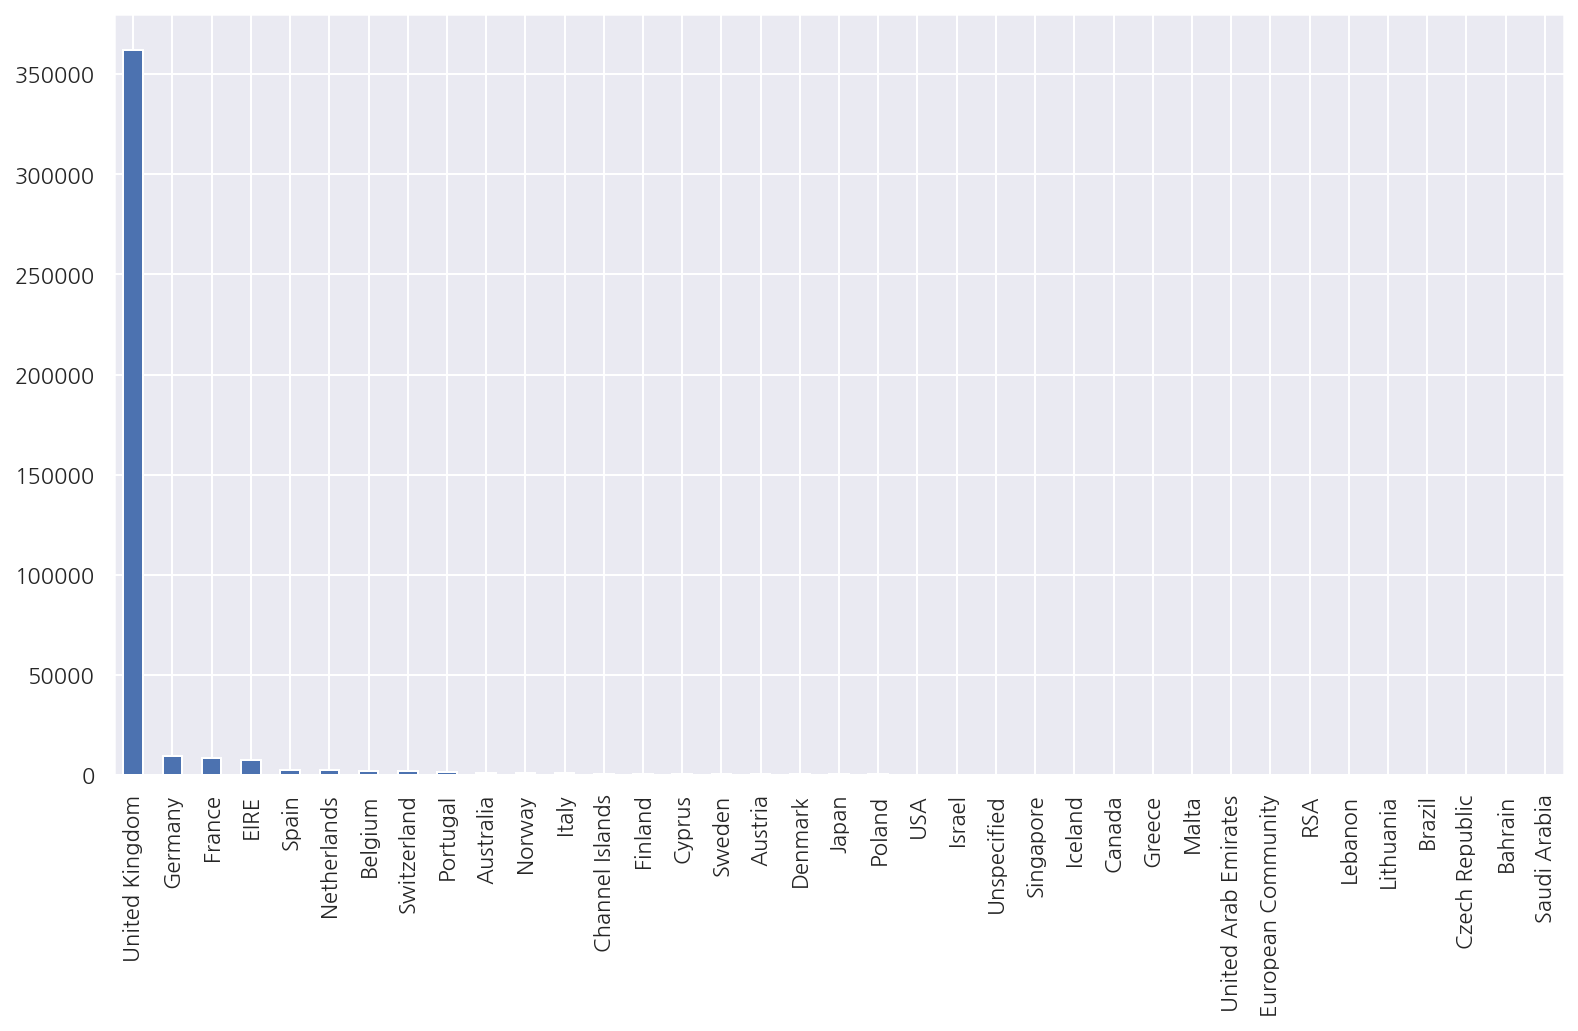

In [5]:
plt.figure(figsize=(13,7))
df['Country'].value_counts().plot(kind='bar')
print("전체 국가 수 : ", df['Country'].nunique())
print("전체 국가중 United Kingdom 비율 : ",len(df[df['Country']== 'United Kingdom'])/len(df))

# United Kingdom을 대상으로 진행
df = df[df['Country'] == 'United Kingdom']

* 고객의 국가정보를 살펴보면 89%의 고객이 영국(UK)에 거주하는것으로 나타난다. 분석의 용이를 위해 영국에 거주하는 고객만을 대상으로 분석을 진행한다.

* 상품 주문 개수와, 상품 가격이 음수인 경우가 존재함. 이는 거래취소,할인,환급인 경우로 추정되므로 제거 후 분석을 진행한다.

In [6]:
display(df['Quantity'].describe())
#  Quantity가 음수인 row 제외 
df = df[df['Quantity'] > 0]

print("#############################")

display(df.UnitPrice.describe())
#  Price가 음수인 row 제외 
df = df[df['UnitPrice'] > 0]

count    361878.000000
mean         11.077029
std         263.129266
min      -80995.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

#############################


count    354345.000000
mean          2.963793
std          17.862067
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

<br>

## < 코호트 분석 >

<br>

### - Cohort 분석이란?
* 코호트 분석이란, 고객을 일정 기준(Time)으로 그룹으로 나누어 고객들의 N경과에 따른 고객 잔존/매출/획득/유지 비교를 통해 신규 고객과 기존 고객의 현황을 파악하는것이다.

<br>
    
### - Cohort를 나누는 기준
* `Time Cohort`
* `Behaviort Cohort`
* `Size Cohort`
    
* 대부분의 경우 Time Cohort를 사용하며 본 문서에서도 시간에 따른 코호트 분석 방법으로 진행한다.

<br>
    
* 본 문서에서 살펴볼 코호트 분석은 아래와 같다.
    * 1. 경과월에 따른 코호트별 고객 유지
    * 2. 월별 총 매출 대비 월별 획득 고객에 의해 발생한 매출액 비교

<br>

* <b> <Cohort - 1. 경과월에 따른 코호트별 고객 유지> </b>

In [7]:
# 전체 고객수(Unique)
print("전체 고객수 : ",df['CustomerID'].nunique())

# 1. 고객별 최초 구매일 구하기
first_purchase = pd.DataFrame()
first_purchase['CustomerID'] = df.groupby('CustomerID')['InvoiceDate'].min().index.astype('object') # 각 고객별 최초 구매일 - index
first_purchase['최초 구매일'] = df.groupby('CustomerID')['InvoiceDate'].min().values # 각 고객별 최초 구매일 - value
first_purchase['최초 구매일'] = first_purchase['최초 구매일'].dt.date # 날짜까지만 출력
display(first_purchase.head())

df = pd.merge(df,first_purchase,how='left') # 원본 데이터에 병합

전체 고객수 :  3920


,CustomerID,최초 구매일
0,12346,2011-01-18
1,12747,2010-12-05
2,12748,2010-12-01
3,12749,2011-05-10
4,12820,2011-01-17


* 고객수는 3920명이며 각 고객별 최초 구매일자를 구하였다.

<br>

* `각 거래별` 해당 고객의 최초 구매일로부터 해당 거래발생 시점까지의 기간(월단위)을 구한다.

In [8]:
# 개월수 구하기 위한 함수
def get_monthly(df):
    start = df['최초 구매일']
    end = df['InvoiceDate']
    
    if start.year == end.year:
        result = end.month - start.month
        return result
    elif start.year < end.year:
        result = (end.month+12) - start.month
        return result
    

df['cohortIndex_monthly'] = df.apply(get_monthly,axis=1)
df['최초 구매일'] = pd.to_datetime(df['최초 구매일'])
display(df[['InvoiceDate','최초 구매일','cohortIndex_monthly']])

,InvoiceDate,최초 구매일,cohortIndex_monthly
0,2010-12-01 08:26:00,2010-12-01,0
1,2010-12-01 08:26:00,2010-12-01,0
2,2010-12-01 08:26:00,2010-12-01,0
3,2010-12-01 08:26:00,2010-12-01,0
4,2010-12-01 08:26:00,2010-12-01,0
...,...,...,...
354316,2011-12-09 12:31:00,2011-05-25,7
354317,2011-12-09 12:49:00,2010-12-08,12
354318,2011-12-09 12:49:00,2010-12-08,12
354319,2011-12-09 12:49:00,2010-12-08,12


<br>

* 고객의 최초구매일(*구매한 월을 기준으로함)을 기준으로 cohort를 나눔

In [9]:
# cohort groupping
# 구매월별 cohort groupping
df['cohort_monthly_group'] = df['최초 구매일'].map(lambda x: x.strftime('%Y-%m'))
df[['최초 구매일','cohort_monthly_group']].head()

,최초 구매일,cohort_monthly_group
0,2010-12-01,2010-12
1,2010-12-01,2010-12
2,2010-12-01,2010-12
3,2010-12-01,2010-12
4,2010-12-01,2010-12


CustomerID                                            \
cohortIndex_monthly          0      1      2      3      4      5      6    
cohort_monthly_group                                                        
2010-12                   815.0  289.0  263.0  304.0  293.0  323.0  291.0   
2011-01                   358.0   76.0   93.0   84.0  119.0   99.0   90.0   
2011-02                   340.0   64.0   66.0   97.0   98.0   86.0   87.0   
2011-03                   419.0   64.0  109.0   83.0   94.0   69.0  111.0   
2011-04                   277.0   58.0   56.0   60.0   56.0   61.0   61.0   
2011-05                   256.0   48.0   44.0   44.0   53.0   58.0   68.0   
2011-06                   214.0   38.0   31.0   51.0   51.0   69.0   21.0   
2011-07                   169.0   30.0   33.0   39.0   47.0   18.0    NaN   
2011-08                   141.0   32.0   32.0   34.0   17.0    NaN    NaN   
2011-09                   276.0   63.0   83.0   32.0    NaN    NaN    NaN   
2011-10                   324.0   79.0   36.0    NaN    NaN    NaN    NaN   
2011-11                   297.0   35.0    NaN    NaN    NaN    NaN    NaN   
2011-12                    34.0    NaN    NaN    NaN    NaN    NaN    NaN   

                                                                
cohortIndex_monthly      7      8      9      10     11     12  
cohort_monthly_group                                            
2010-12               278.0  289.0  325.0  299.0  405.0  218.0  
2011-01                87.0  108.0  117.0  127.0   43.0    NaN  
2011-02                96.0   90.0  104.0   25.0    NaN    NaN  
2011-03                96.0  119.0   38.0    NaN    NaN    NaN  
2011-04                73.0   20.0    NaN    NaN    NaN    NaN  
2011-05                23.0    NaN    NaN    NaN    NaN    NaN  
2011-06                 NaN    NaN    NaN    NaN    NaN    NaN  
2011-07                 NaN    NaN    NaN    NaN    NaN    NaN  
2011-08                 NaN    NaN    NaN    NaN    NaN    NaN  
2011-09                 NaN    NaN    NaN    NaN    NaN    NaN  
2011-10                 NaN    NaN    NaN    NaN    NaN    NaN  
2011-11                 NaN    NaN    NaN    NaN    NaN    NaN  
2011-12                 NaN    NaN    NaN    NaN    NaN    NaN

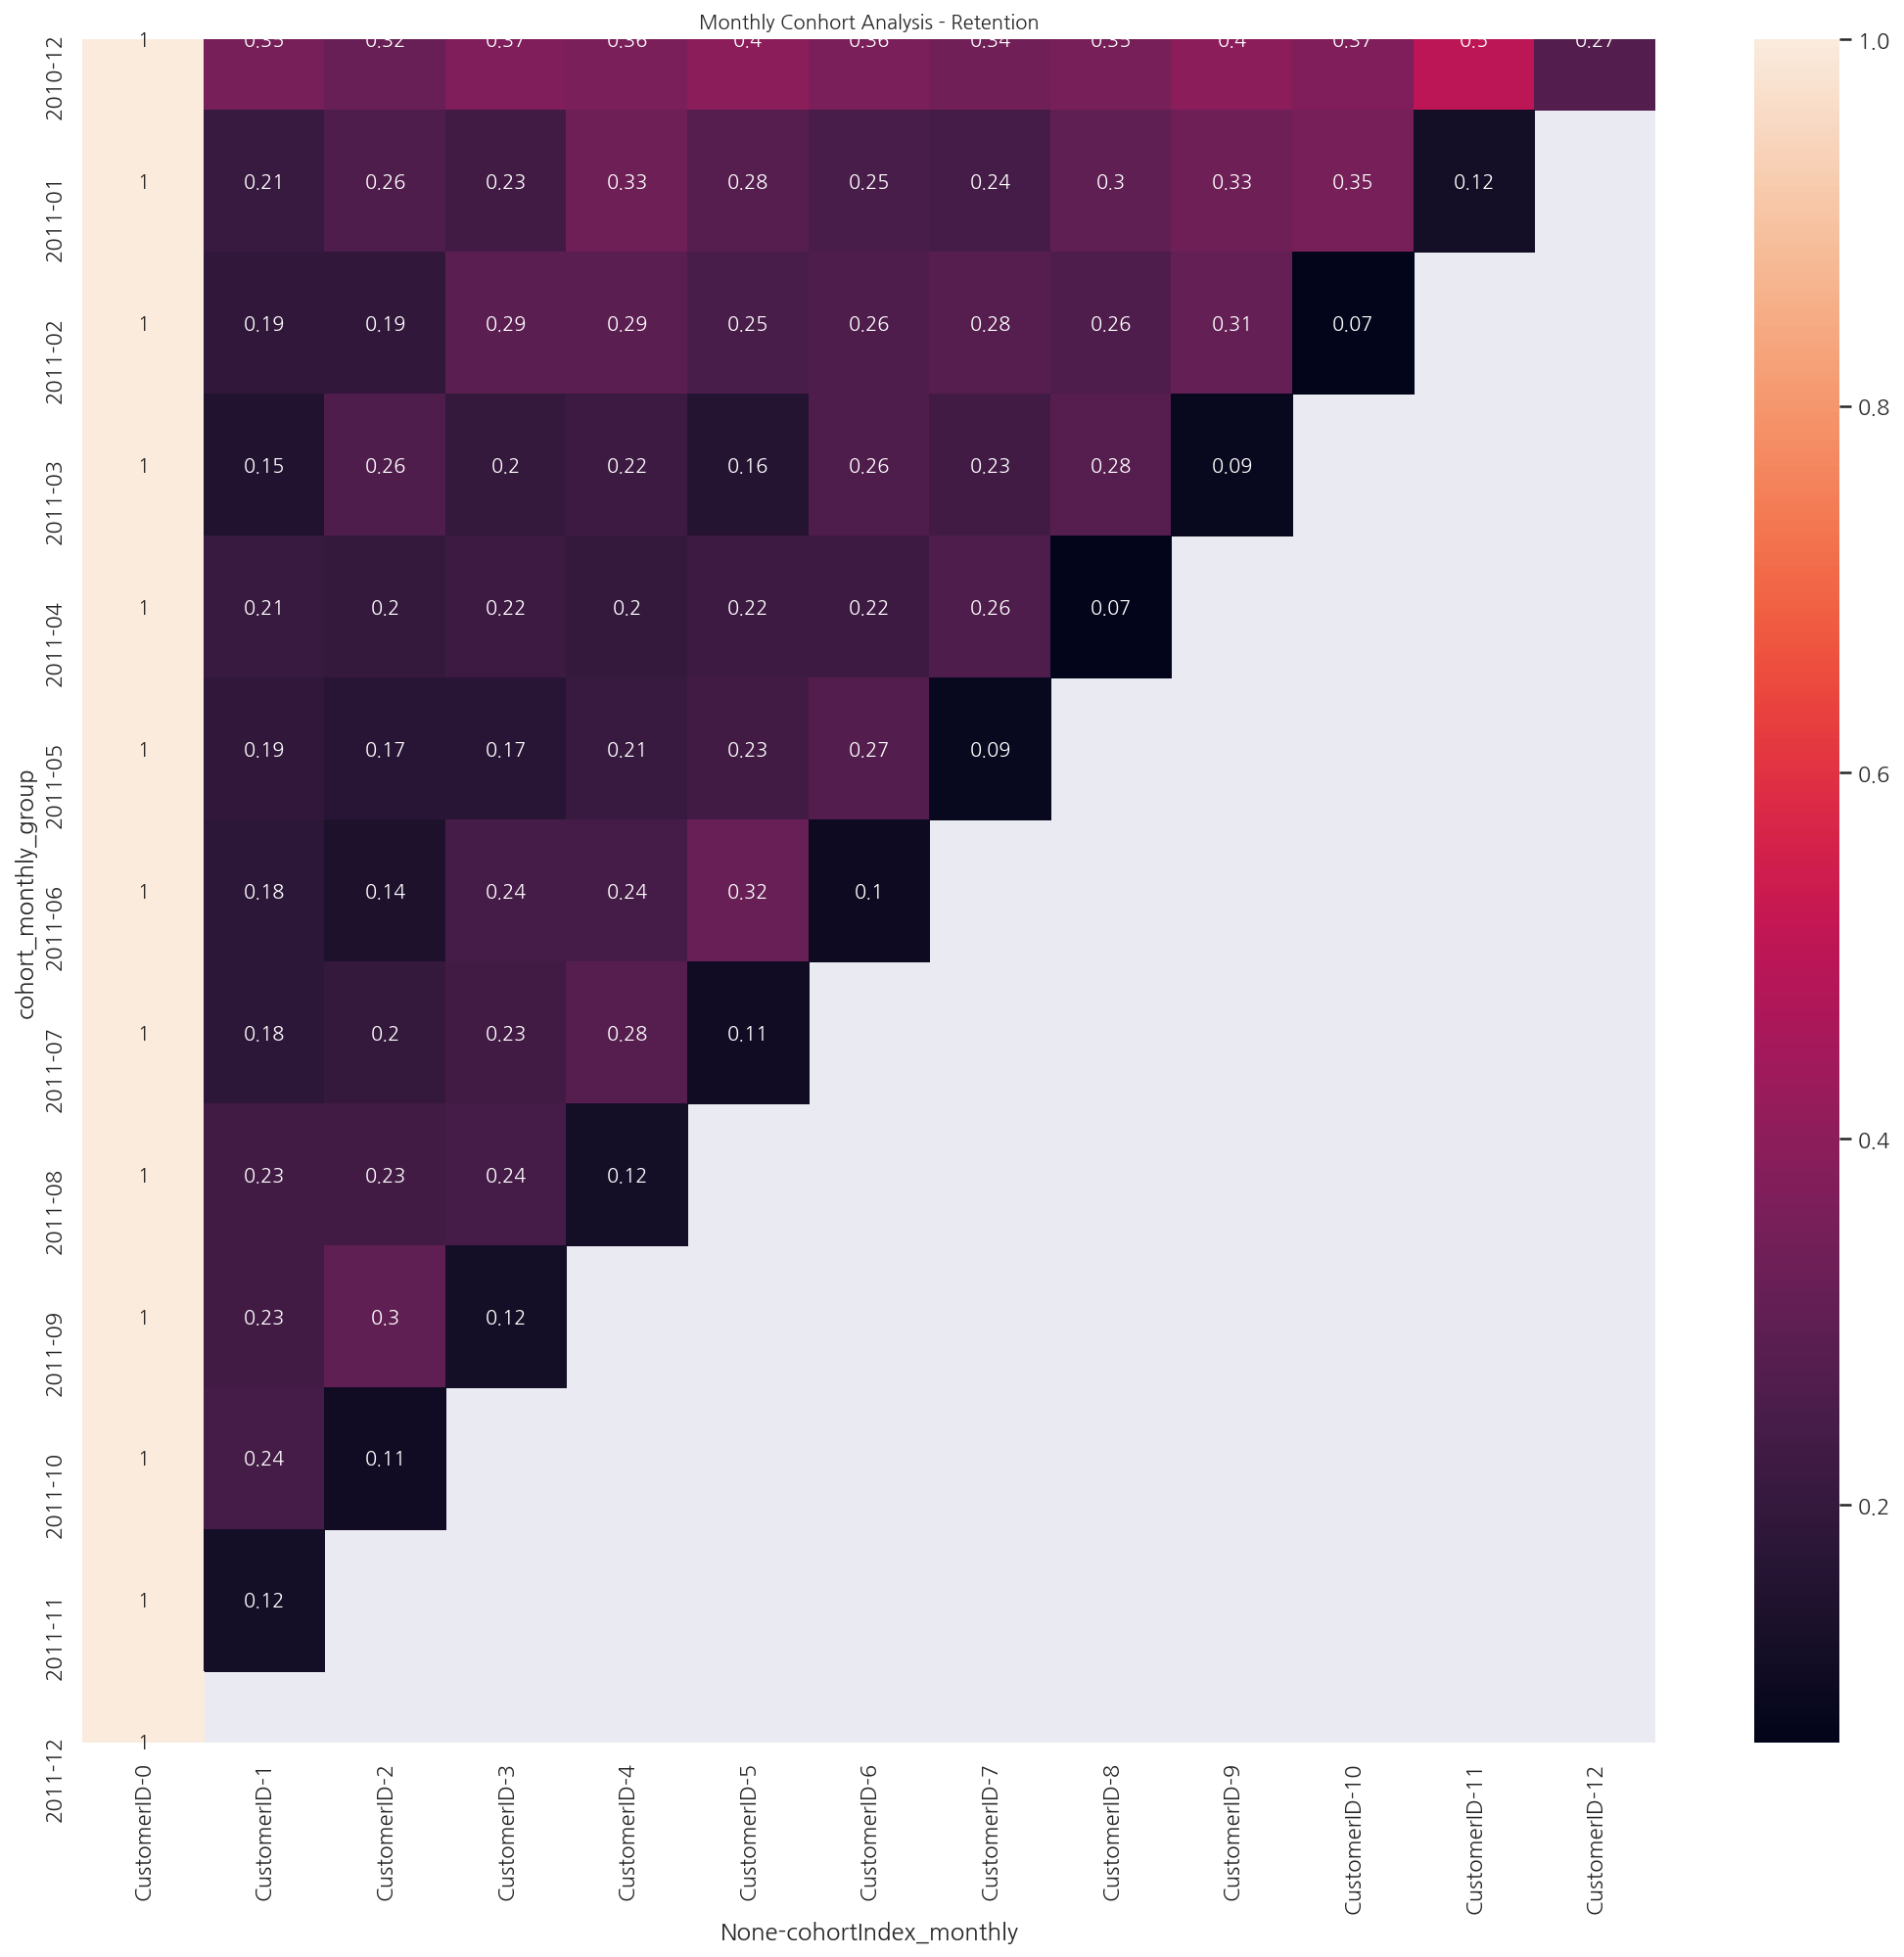

In [10]:
# 같은달 중복구매 여부는 무시한다.
monthly_cohort_retention = df.groupby(['cohort_monthly_group','cohortIndex_monthly'])[['CustomerID']].nunique()

# pivot 형식으로 변경
pivot_1 = monthly_cohort_retention.unstack()
display(pivot_1)


# pivot 테이블의 값을 retention 비율로 변경한 후 시각화
for i in range(len(pivot_1)):
    pivot_1.iloc[i] = round(pivot_1.iloc[i] / pivot_1.iloc[i][0],2)

plt.figure(figsize=(18,16))
sns.heatmap(pivot_1, annot=True)
plt.title('Monthly Conhort Analysis - Retention', fontsize=10)
plt.show()

결과설명

* <b> <Cohort - 2. 월별 총 매출 대비 월별 획득 고객에 의해 발생한 매출액 비교> </b>

In [140]:
##월별 total sales
monthly_total_sales = df.set_index('InvoiceDate').resample('M')['sale_amount'].sum()


## 월별 신규고객에 의한 sales
# (=각 cohort 그룹별 첫달 구매액)
each_cohort_sales = {}

for group in df['cohort_monthly_group'].unique():
    tmp = df[ (df['cohort_monthly_group'] == group) & (df['cohortIndex_monthly'] == 0) ]['sale_amount'].sum()
    each_cohort_sales[group] = tmp

monthly_Cohort_sales = pd.DataFrame(data=each_cohort_sales.values(), 
                                        index=monthly_total_sales.index, 
                                        columns=['first_sales'])

monthly_Cohort_sales['total_sales'] = monthly_total_sales
display(monthly_Cohort_sales)

,first_sales,total_sales
InvoiceDate,,
2010-12-31,498661.850,498661.850
2011-01-31,242600.150,442190.060
2011-02-28,136059.300,355655.630
2011-03-31,170310.370,467198.590
2011-04-30,110249.391,409559.141
2011-05-31,95050.180,551568.820
2011-06-30,107586.470,524915.480
2011-07-31,61486.571,485612.251
2011-08-31,56678.820,498453.320


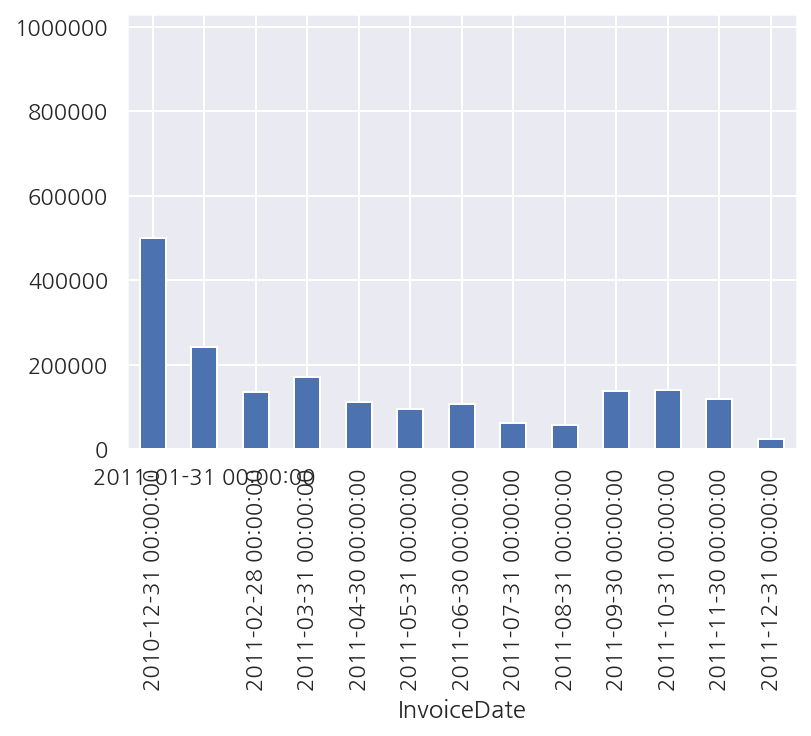

In [151]:
monthly_Cohort_sales['total_sales'].plot(kind='line')
monthly_Cohort_sales['first_sales'].plot(kind='bar')

## < Retention > 

In [ ]:
recent_purchase = pd.DataFrame()

# 2. 고객별 가장 최근 구매일 구하기
recent_purchase['CustomerID'] = df.groupby('CustomerID')['InvoiceDate'].max().index.astype('object')
recent_purchase['최근 구매일'] = df.groupby('CustomerID')['InvoiceDate'].max().values
recent_purchase['최근 구매일'] = recent_purchase['최근 구매일'].dt.date 
display(recent_purchase.head())

In [ ]:
# 전체 데이터, 최근 구매일 병합
df = pd.merge(df,recent_purchase,how='left')
df['최근 구매일'] = pd.to_datetime(df['최근 구매일'])
display(df[['CustomerID','최초 구매일','최근 구매일']].head())

In [ ]:
# 최초 구매일에서 최근 구매일까지의 기간 구하기
df['기간'] = df['최근 구매일'] - df['최초 구매일']
display(df[['CustomerID','최초 구매일','최근 구매일','기간']].head())

# 30Days Rolling Retention
def rolling_30(x):
    x = x.days
    if x >= 30 :
        return 1
    else :
        return 0

df['Rolling_Retention_30'] = df['기간'].apply(rolling_30)

print("전체 고객 수 : ",df['CustomerID'].nunique())
print("30Days Rolling Retention Customer : ",df[df['Rolling_Retention_30'] == 1]['CustomerID'].nunique())
print("전체 고객수 대비 30Days Rolling Retention Rate : ", df[df['Rolling_Retention_30'] == 1]['CustomerID'].nunique() / df['CustomerID'].nunique())

## < RFM >

In [13]:
## 거래금액 col 추가
df['sale_amount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# 개별 고객 기준데이터로 변경
rfm_aggregations = {
    "InvoiceDate" : 'max', # 고객별 가장 최근 구매일
    "InvoiceNo" : 'count', # 고객별 구매 횟수 
    "sale_amount" : "sum" # 고객별 구매합계
}

rfm_df = df.groupby('CustomerID').agg(rfm_aggregations) # 고객ID 기준으로 Gropby

rfm_df = rfm_df.rename(columns={'InvoiceDate':'Recency', 
                                 'InvoiceNo':'Frequency',  
                                 'sale_amount':'Monetary' 
                                 }
                        )

import datetime as dt
rfm_df['Recency'] = dt.datetime(2011,12,10) - rfm_df['Recency']
rfm_df['Recency'] = rfm_df['Recency'].apply(lambda x:x.days+1)

rfm_df = rfm_df.reset_index() # index 초기화
# CustomerID type 변경
rfm_df['CustomerID'] = rfm_df['CustomerID'].astype('object')
rfm_df.head(5)

In [ ]:
# 구매빈도 TOP10 확인
display(rfm_df[['Frequency']].sort_values(by='Frequency',ascending=False).head(10))

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4),nrows=1,ncols=3)
ax1.set_title('Recency 분포')
ax1.hist(rfm_df['Recency'])

ax2.set_title('Frequency 분포')
ax2.hist(rfm_df['Frequency'])

ax3.set_title('Monetary 분포')
ax3.hist(rfm_df['Monetary'])

# R,F,M 통계량
display(rfm_df[['Recency','Frequency','Monetary']].describe())

In [ ]:
r_labels = range(5, 0, -1) # 4,3,2,1
f_labels = range(1, 6) # 1,2,3,4,5
m_labels = range(1, 6) # 1,2,3,4,5

## qcut => 구간 경계선을 지정하지 않고 데이터 갯수가 같도록 지정한 수의 구간으로 나눈다
r_groups = pd.qcut(rfm_df['Recency'], q=5, labels=r_labels) 
f_groups = pd.qcut(rfm_df['Frequency'], q=5, labels=f_labels)
m_groups = pd.qcut(rfm_df['Monetary'], q=5, labels=m_labels)

rfm_df = rfm_df.assign(R = r_groups.values, F = f_groups.values,M = m_groups.values)
rfm_df.head()

In [ ]:
def join_rfm(x): 
    return str(x['R']) + str(x['F']) + str(x['M'])

rfm_df['RFM_Segment_Concat'] = rfm_df.apply(join_rfm, axis=1)
rfm_df = rfm_df

rfm_df['RFM_Score'] = rfm_df[['R','F','M']].sum(axis=1)

rfm_df.head()

In [ ]:
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
    
rfm_df['RFM_Level'] = rfm_df.apply(rfm_level, axis=1)
rfm_df.head()

In [ ]:
rfm_level_agg = rfm_df.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

display(rfm_level_agg)